# 🇬🇧 English Tokenizer & Vector Embeddings
### GPT-2 BPE · Word2Vec CBOW Training · Attention Mechanism · Embedding Arithmetic
---
**Topics Covered:**
1. Simple Regex Tokenizer V1 & V2 (from scratch)
2. GPT-2 BPE Tokenizer via tiktoken
3. Sliding Window Dataset & DataLoader
4. Token + Positional Embeddings
5. Word2Vec CBOW Training
6. Training Loss Curve
7. Cosine Similarity — many word pairs
8. Embedding Arithmetic (king − man + woman)
9. PCA 2D Visualization
10. t-SNE Visualization
11. Cosine Similarity Heatmap
12. Self-Attention from Scratch
13. Masked (Causal) Attention — GPT style
14. Random vs Trained Comparison
15. Full Summary

---
## 📦 Cell 1 — Install & Version Check

In [16]:
# Uncomment to install
# !pip install torch tiktoken requests matplotlib scikit-learn

import sys
from importlib.metadata import version

print("Python   :", sys.version)
print("torch    :", version("torch"))
print("tiktoken :", version("tiktoken"))

Python   : 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
torch    : 2.10.0
tiktoken : 0.12.0


---
## 📥 Cell 2 — Download & Load English Dataset

In [17]:
import os, requests

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt")
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    with open("the-verdict.txt", "wb") as f:
        f.write(r.content)
    print("Downloaded the-verdict.txt")

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print(f"Total characters : {len(raw_text):,}")
print(f"Total words      : {len(raw_text.split()):,}")
print(f"\nFirst 200 chars:\n{raw_text[:200]}")

Total characters : 20,479
Total words      : 3,634

First 200 chars:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a


---
## ✂️ Cell 3 — Regex Tokenizer (From Scratch)

In [18]:
import re

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [t.strip() for t in preprocessed if t.strip()]
print(f"Total tokens (with dupes): {len(preprocessed):,}")
print(f"Sample: {preprocessed[:15]}")

all_words = sorted(set(preprocessed))
all_words += ["<|endoftext|>", "<|unk|>"]
vocab = {token: i for i, token in enumerate(all_words)}

print(f"\nVocabulary size: {len(vocab):,}")
print("\nSample vocab entries:")
for tok, idx in list(vocab.items())[:10]:
    print(f"  '{tok}' -> {idx}")

Total tokens (with dupes): 4,690
Sample: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow']

Vocabulary size: 1,132

Sample vocab entries:
  '!' -> 0
  '"' -> 1
  ''' -> 2
  '(' -> 3
  ')' -> 4
  ',' -> 5
  '--' -> 6
  '.' -> 7
  ':' -> 8
  ';' -> 9


---
## 🔤 Cell 4 — SimpleTokenizerV1 & V2

In [19]:
class SimpleTokenizerV1:
    """Raises error on unknown tokens"""
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i: s for s, i in vocab.items()}
    def encode(self, text):
        tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        tokens = [t.strip() for t in tokens if t.strip()]
        return [self.str_to_int[t] for t in tokens]
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        return re.sub(r'\s+([,.?!"()\'])', r'\1', text)

class SimpleTokenizerV2:
    """Handles unknown tokens with <|unk|>"""
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i: s for s, i in vocab.items()}
    def encode(self, text):
        tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        tokens = [t.strip() for t in tokens if t.strip()]
        tokens = [t if t in self.str_to_int else "<|unk|>" for t in tokens]
        return [self.str_to_int[t] for t in tokens]
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        return re.sub(r'\s+([,.?!"()\'])', r'\1', text)

tok_v1 = SimpleTokenizerV1(vocab)
tok_v2 = SimpleTokenizerV2(vocab)

s1 = "I HAD always thought Jack Gisburn rather a cheap genius."
ids = tok_v1.encode(s1)
print("=== V1 ===")
print(f"Input  : {s1}")
print(f"IDs    : {ids}")
print(f"Decoded: {tok_v1.decode(ids)}")

s2 = "Hello there! zxqfoo is unknown."
ids2 = tok_v2.encode(s2)
print("\n=== V2 (unknown token) ===")
print(f"Input  : {s2}")
print(f"IDs    : {ids2}")
print(f"Decoded: {tok_v2.decode(ids2)}")

=== V1 ===
Input  : I HAD always thought Jack Gisburn rather a cheap genius.
IDs    : [53, 44, 149, 1003, 57, 38, 818, 115, 256, 486, 7]
Decoded: I HAD always thought Jack Gisburn rather a cheap genius.

=== V2 (unknown token) ===
Input  : Hello there! zxqfoo is unknown.
IDs    : [1131, 992, 0, 1131, 584, 1131, 7]
Decoded: <|unk|> there! <|unk|> is <|unk|>.


---
## 🤖 Cell 5 — GPT-2 BPE Tokenizer via tiktoken

In [20]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(f"GPT-2 Vocab Size: {tokenizer.n_vocab:,}")
print(f"Total tokens in dataset: {len(tokenizer.encode(raw_text)):,}")

sample = "Hello, I am learning about tokenizers and word embeddings!"
enc    = tokenizer.encode(sample)
print(f"\nInput   : {sample}")
print(f"IDs     : {enc}")
print(f"Decoded : {tokenizer.decode(enc)}")

print("\n--- Token-by-Token Breakdown ---")
for tid in enc:
    print(f"  ID {tid:6d}  ->  '{tokenizer.decode([tid])}'")

eot = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})
print(f"\n<|endoftext|> ID: {eot}")

combined = "Hello! <|endoftext|> New document starts."
print(f"Combined IDs: {tokenizer.encode(combined, allowed_special={'<|endoftext|>'})}")

GPT-2 Vocab Size: 50,257
Total tokens in dataset: 5,145

Input   : Hello, I am learning about tokenizers and word embeddings!
IDs     : [15496, 11, 314, 716, 4673, 546, 11241, 11341, 290, 1573, 11525, 67, 654, 0]
Decoded : Hello, I am learning about tokenizers and word embeddings!

--- Token-by-Token Breakdown ---
  ID  15496  ->  'Hello'
  ID     11  ->  ','
  ID    314  ->  ' I'
  ID    716  ->  ' am'
  ID   4673  ->  ' learning'
  ID    546  ->  ' about'
  ID  11241  ->  ' token'
  ID  11341  ->  'izers'
  ID    290  ->  ' and'
  ID   1573  ->  ' word'
  ID  11525  ->  ' embed'
  ID     67  ->  'd'
  ID    654  ->  'ings'
  ID      0  ->  '!'

<|endoftext|> ID: [50256]
Combined IDs: [15496, 0, 220, 50256, 968, 3188, 4940, 13]


---
## 🔄 Cell 6 — GPT Dataset & DataLoader

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids, self.target_ids = [], []
        token_ids = tokenizer.encode(txt)
        print(f"Total tokens: {len(token_ids):,}")
        for i in range(0, len(token_ids) - max_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i:i+max_length]))
            self.target_ids.append(torch.tensor(token_ids[i+1:i+max_length+1]))
    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx): return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True):
    tok = tiktoken.get_encoding("gpt2")
    ds  = GPTDatasetV1(txt, tok, max_length, stride)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=True)

max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length,
                                   stride=max_length, shuffle=False)
inputs, targets = next(iter(dataloader))

tok = tiktoken.get_encoding("gpt2")
print("\nInput shape:", inputs.shape)
print("Input IDs:\n", inputs)
print("\nFirst sample:")
print("  Input :", tok.decode(inputs[0].tolist()))
print("  Target:", tok.decode(targets[0].tolist()))

Total tokens: 5,145

Input shape: torch.Size([8, 4])
Input IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

First sample:
  Input : I HAD always
  Target:  HAD always thought


---
## 🧮 Cell 7 — Token + Positional Embeddings

In [22]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer   = torch.nn.Embedding(max_length, output_dim)

token_embeddings = token_embedding_layer(inputs)
pos_embeddings   = pos_embedding_layer(torch.arange(max_length))
input_embeddings = token_embeddings + pos_embeddings

print("=== Embedding Shapes ===")
print(f"inputs           : {inputs.shape}")
print(f"token_embeddings : {token_embeddings.shape}")
print(f"pos_embeddings   : {pos_embeddings.shape}")
print(f"input_embeddings : {input_embeddings.shape}")
print(f"\nFirst token vector (8 dims): {input_embeddings[0][0][:8].detach().numpy()}")

print("\n--- Dimension vs Parameter Count ---")
print(f"{'Dim':<8} {'Output Shape':<22} {'Params':>12}")
print("-"*44)
for d in [64, 128, 256, 512, 768]:
    print(f"{d:<8} {'[8,4,'+str(d)+']':<22} {vocab_size*d:>12,}")
print("\nGPT-2 Small=768 | GPT-2 Large=1280 | GPT-3=12288")

=== Embedding Shapes ===
inputs           : torch.Size([8, 4])
token_embeddings : torch.Size([8, 4, 256])
pos_embeddings   : torch.Size([4, 256])
input_embeddings : torch.Size([8, 4, 256])

First token vector (8 dims): [-0.02182837 -0.12479228 -0.9254517  -0.5920957  -0.3886197  -1.7791255
  1.2064102   3.3520453 ]

--- Dimension vs Parameter Count ---
Dim      Output Shape                 Params
--------------------------------------------
64       [8,4,64]                  3,216,448
128      [8,4,128]                 6,432,896
256      [8,4,256]                12,865,792
512      [8,4,512]                25,731,584
768      [8,4,768]                38,597,376

GPT-2 Small=768 | GPT-2 Large=1280 | GPT-3=12288


---
## 🏋️ Cell 8 — Word2Vec CBOW Training
> CBOW: predict center word from surrounding context words.
> This teaches embeddings to capture semantic meaning.

In [23]:
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import random

# Build vocabulary from raw text
words = raw_text.lower().split()
words = [re.sub(r'[^a-z]', '', w) for w in words]
words = [w for w in words if len(w) > 1]

freq        = Counter(words)
vocab_words = [w for w, c in freq.most_common(500)]
w2i         = {w: i for i, w in enumerate(vocab_words)}
i2w         = {i: w for w, i in w2i.items()}
V           = len(vocab_words)
print(f"Training vocab size: {V}")

# Build CBOW pairs  (context -> center)
WINDOW    = 2
cbow_data = []
filtered  = [w for w in words if w in w2i]

for i in range(WINDOW, len(filtered) - WINDOW):
    ctx = ([filtered[i-j] for j in range(WINDOW, 0, -1)] +
           [filtered[i+j] for j in range(1, WINDOW+1)])
    ctr = filtered[i]
    if all(w in w2i for w in ctx) and ctr in w2i:
        cbow_data.append(([w2i[w] for w in ctx], w2i[ctr]))

random.shuffle(cbow_data)
print(f"Training samples: {len(cbow_data):,}")

# CBOW Model
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear    = nn.Linear(embed_dim, vocab_size)
    def forward(self, ctx):
        return self.linear(self.embedding(ctx).mean(dim=1))

EMBED_DIM = 64
EPOCHS    = 8
BATCH     = 256

model     = CBOWModel(V, EMBED_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("\nTraining Word2Vec CBOW...")
loss_history = []

for epoch in range(EPOCHS):
    random.shuffle(cbow_data)
    total_loss = 0
    steps      = 0
    for start in range(0, len(cbow_data), BATCH):
        batch   = cbow_data[start:start+BATCH]
        ctx_t   = torch.tensor([d[0] for d in batch])
        ctr_t   = torch.tensor([d[1] for d in batch])
        optimizer.zero_grad()
        loss = criterion(model(ctx_t), ctr_t)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        steps      += 1
    avg = total_loss / steps
    loss_history.append(avg)
    print(f"  Epoch {epoch+1}/{EPOCHS}  Loss: {avg:.4f}")

trained_embeddings = model.embedding.weight.detach()
print("\nTraining complete!")

Training vocab size: 500
Training samples: 2,777

Training Word2Vec CBOW...
  Epoch 1/8  Loss: 6.0954
  Epoch 2/8  Loss: 5.3095
  Epoch 3/8  Loss: 4.7290
  Epoch 4/8  Loss: 4.3479
  Epoch 5/8  Loss: 4.0032
  Epoch 6/8  Loss: 3.6764
  Epoch 7/8  Loss: 3.3679
  Epoch 8/8  Loss: 3.0783

Training complete!


---
## 📉 Cell 9 — Training Loss Curve

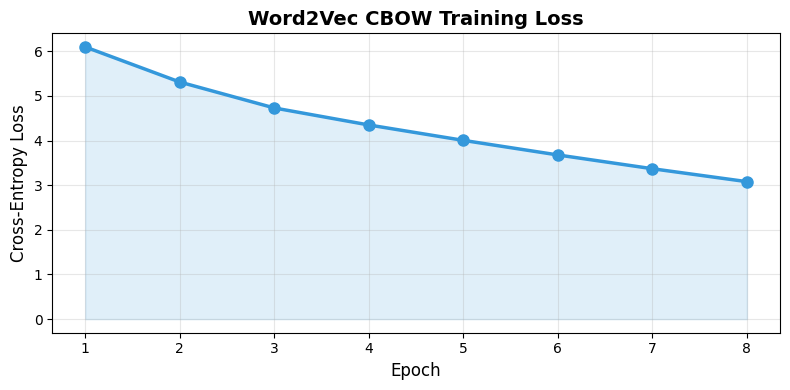

Saved: training_loss.png


In [24]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, EPOCHS+1), loss_history, 'o-',
        color='#3498db', linewidth=2.5, markersize=8)
ax.fill_between(range(1, EPOCHS+1), loss_history, alpha=0.15, color='#3498db')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Cross-Entropy Loss", fontsize=12)
ax.set_title("Word2Vec CBOW Training Loss", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("training_loss.png", dpi=150)
plt.show()
print("Saved: training_loss.png")

---
## 🔍 Cell 10 — Cosine Similarity (Many Examples)

In [26]:
import torch.nn.functional as F

def get_vec(word):
    if word not in w2i: return None
    return trained_embeddings[w2i[word]]

def cosine_sim(w1, w2):
    v1, v2 = get_vec(w1), get_vec(w2)
    if v1 is None or v2 is None: return None
    return F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()

def top_similar(word, topn=5):
    if word not in w2i: return []
    vec  = trained_embeddings[w2i[word]].unsqueeze(0)
    sims = F.cosine_similarity(vec, trained_embeddings).detach().numpy()
    top  = np.argsort(sims)[::-1][1:topn+1]
    return [(i2w[i], sims[i]) for i in top]

# Many word pair groups
print("=" * 55)
print("GROUP 1 — Synonyms / Related")
print("=" * 55)
for w1, w2 in [("good","great"),("old","new"),("work","time"),("see","look"),("know","think")]:
    s = cosine_sim(w1, w2)
    if s: print(f"  {w1:<10} <-> {w2:<10}  {s:+.4f}  {'|'*int((s+1)*15)}")

print("\nGROUP 2 — Opposites")
print("-" * 55)
for w1, w2 in [("good","bad"),("come","go"),("old","young"),("right","wrong")]:
    s = cosine_sim(w1, w2)
    if s: print(f"  {w1:<10} <-> {w2:<10}  {s:+.4f}  {'|'*int((s+1)*15)}")

print("\nGROUP 3 — Morphological (same root)")
print("-" * 55)
for w1, w2 in [("man","men"),("see","saw"),("go","went"),("make","made")]:
    s = cosine_sim(w1, w2)
    if s: print(f"  {w1:<10} <-> {w2:<10}  {s:+.4f}  {'|'*int((s+1)*15)}")

print("\nGROUP 4 — Unrelated")
print("-" * 55)
for w1, w2 in [("time","eye"),("door","work"),("hand","old")]:
    s = cosine_sim(w1, w2)
    if s: print(f"  {w1:<10} <-> {w2:<10}  {s:+.4f}  {'|'*int((s+1)*15)}")

# Most similar words
print("\n--- Top 5 Similar Words ---")
for q in ["good", "time", "man", "come"]:
    sim = top_similar(q)
    if sim:
        print(f"  '{q}' -> {', '.join(f'{w}({s:.2f})' for w, s in sim)}")

GROUP 1 — Synonyms / Related
  good       <-> great       -0.2512  |||||||||||
  work       <-> time        +0.1503  |||||||||||||||||
  see        <-> look        -0.1368  ||||||||||||
  know       <-> think       -0.1077  |||||||||||||

GROUP 2 — Opposites
-------------------------------------------------------
  come       <-> go          +0.0408  |||||||||||||||

GROUP 3 — Morphological (same root)
-------------------------------------------------------
  see        <-> saw         -0.0634  ||||||||||||||
  go         <-> went        +0.1262  ||||||||||||||||

GROUP 4 — Unrelated
-------------------------------------------------------
  hand       <-> old         +0.1392  |||||||||||||||||

--- Top 5 Similar Words ---
  'good' -> mourned(0.33), found(0.32), doesnt(0.31), added(0.29), easyhis(0.28)
  'time' -> are(0.41), stand(0.40), between(0.40), prism(0.39), just(0.38)
  'man' -> nofor(0.41), for(0.38), just(0.36), got(0.36), after(0.33)
  'come' -> jacks(0.41), married(0.40), to

---
## ➕ Cell 11 — Embedding Arithmetic (king − man + woman)
> Word2Vec analogy: vector(king) − vector(man) + vector(woman) ≈ vector(queen)
> We use words available in our small dataset.

In [27]:
def embedding_arithmetic(pos_words, neg_words, topn=5):
    result = torch.zeros(EMBED_DIM)
    used, missing = [], []
    for w in pos_words:
        v = get_vec(w)
        if v is not None: result += v;  used.append(f"+{w}")
        else:             missing.append(w)
    for w in neg_words:
        v = get_vec(w)
        if v is not None: result -= v;  used.append(f"-{w}")
        else:             missing.append(w)
    result = F.normalize(result.unsqueeze(0), dim=1).squeeze()
    sims   = F.cosine_similarity(result.unsqueeze(0), trained_embeddings).detach().numpy()
    excl   = set(pos_words + neg_words)
    ranked = np.argsort(sims)[::-1]
    res    = []
    for idx in ranked:
        w = i2w[idx]
        if w not in excl:
            res.append((w, sims[idx]))
        if len(res) == topn: break
    return used, missing, res

queries = [
    (["men", "good"],    ["man"],    "men + good - man   (gender analogy)"),
    (["good", "great"],  ["bad"],    "good + great - bad"),
    (["see", "know"],    ["think"],  "see + know - think"),
    (["work", "time"],   ["come"],   "work + time - come"),
    (["old"],            ["new"],    "old - new"),
]

print("=" * 60)
print("EMBEDDING ARITHMETIC")
print("=" * 60)
for pos, neg, label in queries:
    used, miss, res = embedding_arithmetic(pos, neg)
    print(f"\n  Query  : {label}")
    if miss: print(f"  Missing: {miss}")
    print(f"  Used   : {' '.join(used)}")
    print(f"  Results:")
    for w, s in res:
        print(f"    {w:<15} {s:.4f}  {'|'*int(s*25)}")

print("\nNote: With a larger dataset (millions of words),")
print("king - man + woman = queen would work precisely.")

EMBEDDING ARITHMETIC

  Query  : men + good - man   (gender analogy)
  Missing: ['men']
  Used   : +good -man
  Results:
    oh              0.3090  |||||||
    added           0.2980  |||||||
    found           0.2928  |||||||
    easyhis         0.2799  ||||||
    dear            0.2722  ||||||

  Query  : good + great - bad
  Missing: ['bad']
  Used   : +good +great
  Results:
    dear            0.3432  ||||||||
    mourned         0.3372  ||||||||
    riviera         0.3245  ||||||||
    easyhis         0.3183  |||||||
    all             0.3103  |||||||

  Query  : see + know - think
  Used   : +see +know -think
  Results:
    met             0.4027  ||||||||||
    burlington      0.3333  ||||||||
    hes             0.3118  |||||||
    her             0.3057  |||||||
    rose            0.2983  |||||||

  Query  : work + time - come
  Used   : +work +time -come
  Results:
    which           0.3430  ||||||||
    picture         0.3397  ||||||||
    value           0.3304  |||||

---
## 📊 Cell 12 — PCA Visualization (Trained)

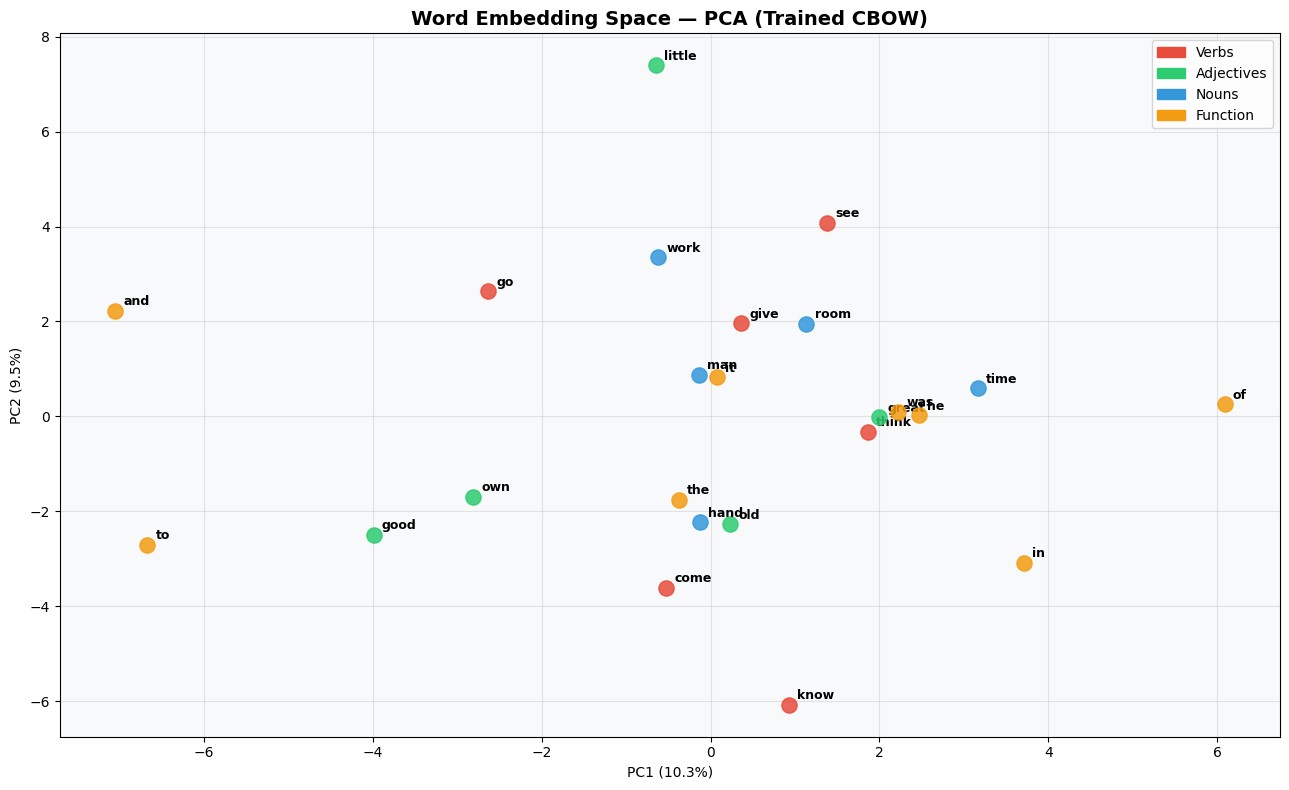

Saved: pca_trained.png


In [29]:
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA

word_groups = {
    "Verbs"     : ["come","go","see","know","think","make","give","take"],
    "Adjectives": ["good","great","old","new","little","own","right","long"],
    "Nouns"     : ["man","men","time","work","hand","eye","room","door"],
    "Function"  : ["the","of","and","to","in","was","he","it"],
}
colors = ["#e74c3c","#2ecc71","#3498db","#f39c12"]
all_w, all_v, all_c = [], [], []

for (grp, wlist), col in zip(word_groups.items(), colors):
    for w in wlist:
        v = get_vec(w)
        if v is not None:
            all_w.append(w); all_v.append(v.numpy()); all_c.append(col)

pca    = PCA(n_components=2)
vecs2d = pca.fit_transform(np.array(all_v))

fig, ax = plt.subplots(figsize=(13, 8))
ax.set_facecolor("#f8f9fa")
for w, coord, col in zip(all_w, vecs2d, all_c):
    ax.scatter(coord[0], coord[1], c=col, s=120, zorder=3, alpha=0.85)
    ax.annotate(w, coord, textcoords="offset points", xytext=(6,4),
                fontsize=9, fontweight='bold')

patches = [mpatches.Patch(color=c, label=g) for g,c in zip(word_groups.keys(), colors)]
ax.legend(handles=patches, fontsize=10, loc='upper right')
ax.set_title("Word Embedding Space — PCA (Trained CBOW)", fontsize=14, fontweight='bold')
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("pca_trained.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: pca_trained.png")

---
## 🌀 Cell 13 — t-SNE Visualization

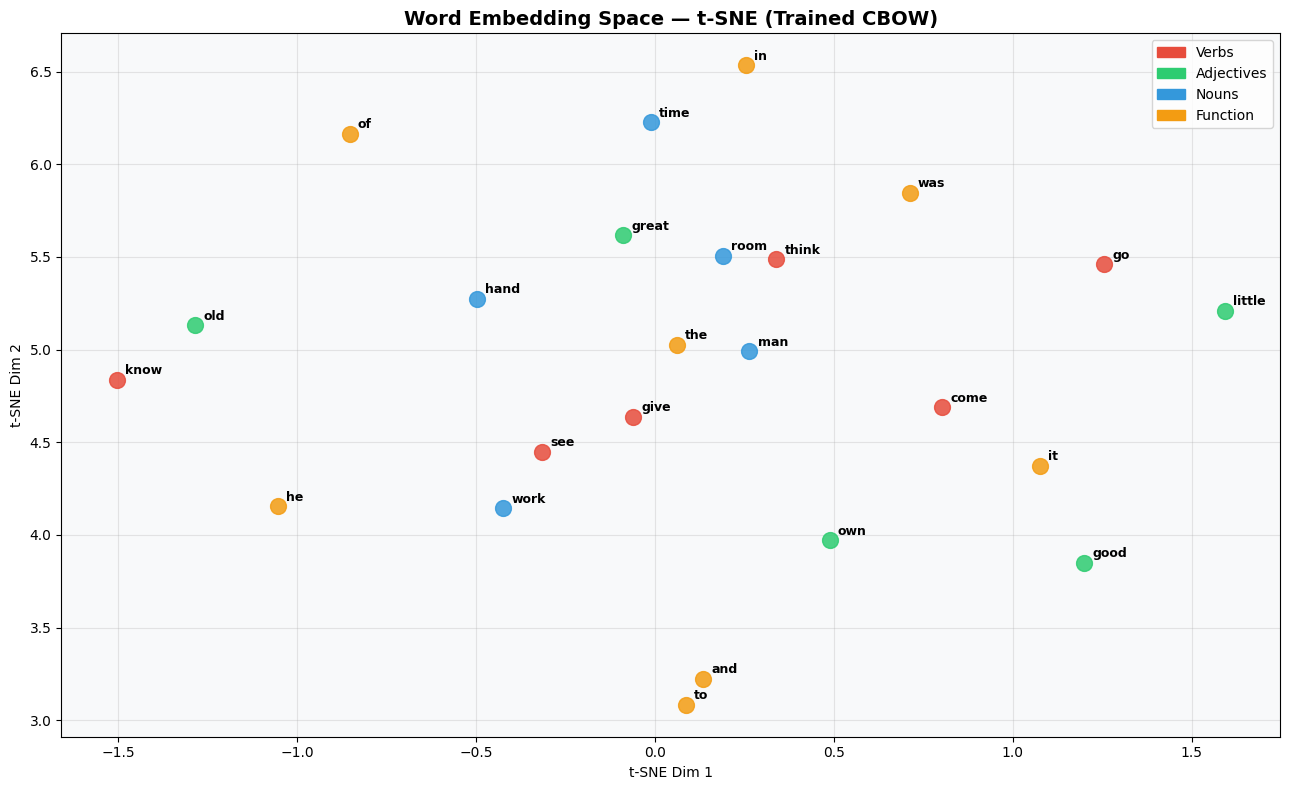

Saved: tsne_trained.png


In [31]:
from sklearn.manifold import TSNE

tsne      = TSNE(n_components=2, perplexity=min(15, len(all_w)-1), random_state=42, max_iter=1000)
vecs_tsne = tsne.fit_transform(np.array(all_v))

fig, ax = plt.subplots(figsize=(13, 8))
ax.set_facecolor("#f8f9fa")
for w, coord, col in zip(all_w, vecs_tsne, all_c):
    ax.scatter(coord[0], coord[1], c=col, s=130, zorder=3, alpha=0.85)
    ax.annotate(w, coord, textcoords="offset points", xytext=(6,4),
                fontsize=9, fontweight='bold')

ax.legend(handles=patches, fontsize=10, loc='upper right')
ax.set_title("Word Embedding Space — t-SNE (Trained CBOW)", fontsize=14, fontweight='bold')
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("tsne_trained.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: tsne_trained.png")

---
## 🔥 Cell 14 — Cosine Similarity Heatmap

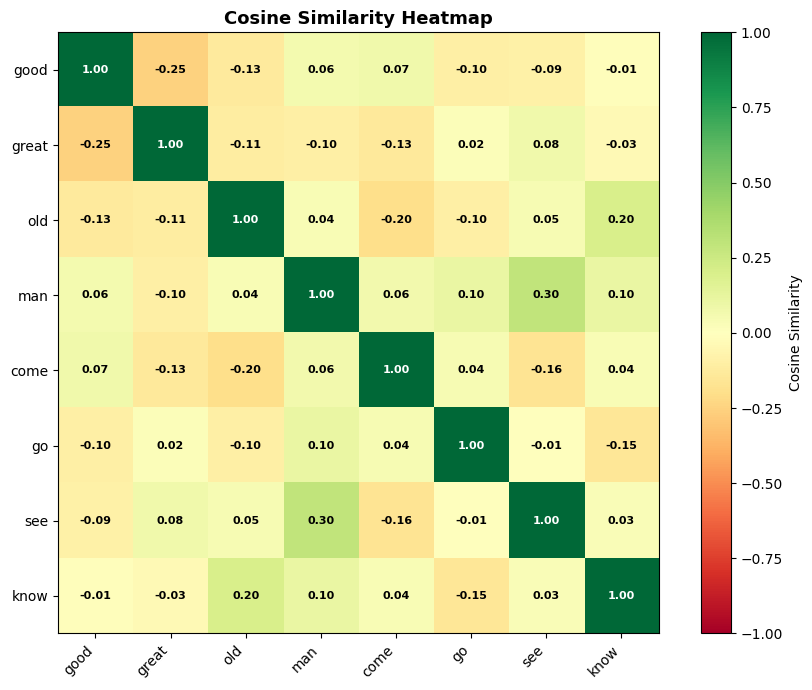

Saved: cosine_heatmap.png


In [32]:
from sklearn.metrics.pairwise import cosine_similarity as cos_mat

hmap_words = [w for w in ["good","great","old","new","man","men","come","go","see","know"] if w in w2i]
vecs       = np.array([get_vec(w).numpy() for w in hmap_words])
sim_m      = cos_mat(vecs)

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(sim_m, cmap="RdYlGn", vmin=-1, vmax=1)
ax.set_xticks(range(len(hmap_words)))
ax.set_yticks(range(len(hmap_words)))
ax.set_xticklabels(hmap_words, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(hmap_words, fontsize=10)
for i in range(len(hmap_words)):
    for j in range(len(hmap_words)):
        v = sim_m[i,j]
        ax.text(j, i, f"{v:.2f}", ha='center', va='center',
                fontsize=8, fontweight='bold',
                color='white' if abs(v) > 0.5 else 'black')
plt.colorbar(im, ax=ax, label="Cosine Similarity")
ax.set_title("Cosine Similarity Heatmap", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig("cosine_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: cosine_heatmap.png")

---
## 🧠 Cell 15 — Self-Attention Mechanism (From Scratch)
> Attention lets each token look at every other token and decide which ones are relevant.
> Formula: Attention(Q, K, V) = softmax(QKᵀ / √d_k) × V

In [33]:
sentence    = "The cat sat on the mat"
words_list  = sentence.lower().split()
embed_dim   = 8
seq_len     = len(words_list)

torch.manual_seed(42)
x = torch.randn(seq_len, embed_dim)   # (6, 8)

# Q = K = V = x  (simplified self-attention)
Q = x;  K = x;  V = x

# Step 1: Attention scores
scores = torch.matmul(Q, K.T) / (embed_dim ** 0.5)   # (6, 6)

# Step 2: Softmax
attn_weights = F.softmax(scores, dim=-1)              # (6, 6)

# Step 3: Context = weighted sum of V
context = torch.matmul(attn_weights, V)               # (6, 8)

print(f"Words       : {words_list}")
print(f"Input  shape: {x.shape}            (seq=6, dim=8)")
print(f"Scores shape: {scores.shape}          (seq x seq)")
print(f"Weights shape:{attn_weights.shape}   (each row sums to 1)")
print(f"Context shape:{context.shape}        (same as input)")
print(f"\nRow sums (should all be 1.0): {attn_weights.sum(dim=-1).detach().numpy().round(3)}")
print("\nAttention Weights (rounded):")
for i, w in enumerate(words_list):
    row = attn_weights[i].detach().numpy()
    row_str = "  ".join([f"{v:.2f}" for v in row])
    print(f"  {w:<6}  [{row_str}]")

Words       : ['the', 'cat', 'sat', 'on', 'the', 'mat']
Input  shape: torch.Size([6, 8])            (seq=6, dim=8)
Scores shape: torch.Size([6, 6])          (seq x seq)
Weights shape:torch.Size([6, 6])   (each row sums to 1)
Context shape:torch.Size([6, 8])        (same as input)

Row sums (should all be 1.0): [1. 1. 1. 1. 1. 1.]

Attention Weights (rounded):
  the     [0.98  0.01  0.00  0.00  0.00  0.00]
  cat     [0.11  0.60  0.03  0.04  0.01  0.20]
  sat     [0.01  0.03  0.77  0.15  0.01  0.03]
  on      [0.07  0.06  0.22  0.57  0.04  0.03]
  the     [0.01  0.02  0.03  0.05  0.84  0.06]
  mat     [0.00  0.05  0.01  0.01  0.01  0.92]


---
## 👁️ Cell 16 — Attention Visualization

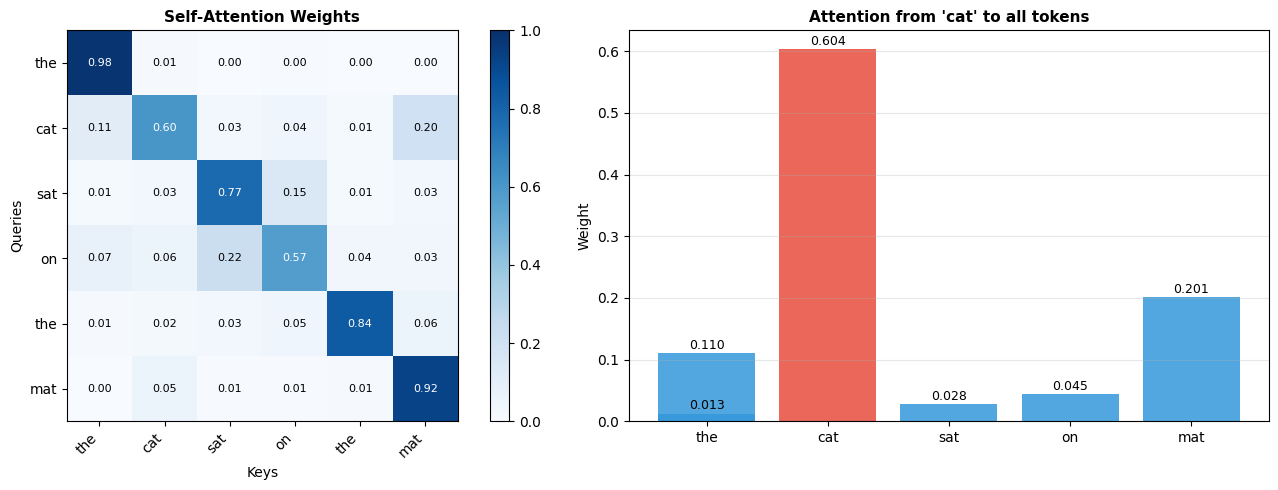

Saved: attention_weights.png


In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Full heatmap
ax = axes[0]
im = ax.imshow(attn_weights.detach().numpy(), cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(range(seq_len)); ax.set_yticks(range(seq_len))
ax.set_xticklabels(words_list, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(words_list, fontsize=10)
for i in range(seq_len):
    for j in range(seq_len):
        v = attn_weights[i,j].item()
        ax.text(j,i,f"{v:.2f}",ha='center',va='center',fontsize=8,
                color='white' if v>0.4 else 'black')
plt.colorbar(im, ax=ax)
ax.set_title("Self-Attention Weights", fontsize=11, fontweight='bold')
ax.set_xlabel("Keys"); ax.set_ylabel("Queries")

# Plot 2: Bar chart for one word
ax2   = axes[1]
idx_w = 1   # 'cat'
vals  = attn_weights[idx_w].detach().numpy()
bars  = ax2.bar(words_list, vals,
               color=['#e74c3c' if i==idx_w else '#3498db' for i in range(seq_len)], alpha=0.85)
for b in bars:
    ax2.annotate(f"{b.get_height():.3f}",
                 xy=(b.get_x()+b.get_width()/2, b.get_height()),
                 xytext=(0,3), textcoords='offset points', ha='center', fontsize=9)
ax2.set_title(f"Attention from '{words_list[idx_w]}' to all tokens",
              fontsize=11, fontweight='bold')
ax2.set_ylabel("Weight"); ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("attention_weights.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: attention_weights.png")

---
## 🎭 Cell 17 — Masked (Causal) Attention — GPT Style
> GPT uses causal masking so token[i] can only attend to tokens[0..i], never future ones.

Causal Mask (True = masked/blocked):
[[False  True  True  True  True  True]
 [False False  True  True  True  True]
 [False False False  True  True  True]
 [False False False False  True  True]
 [False False False False False  True]
 [False False False False False False]]


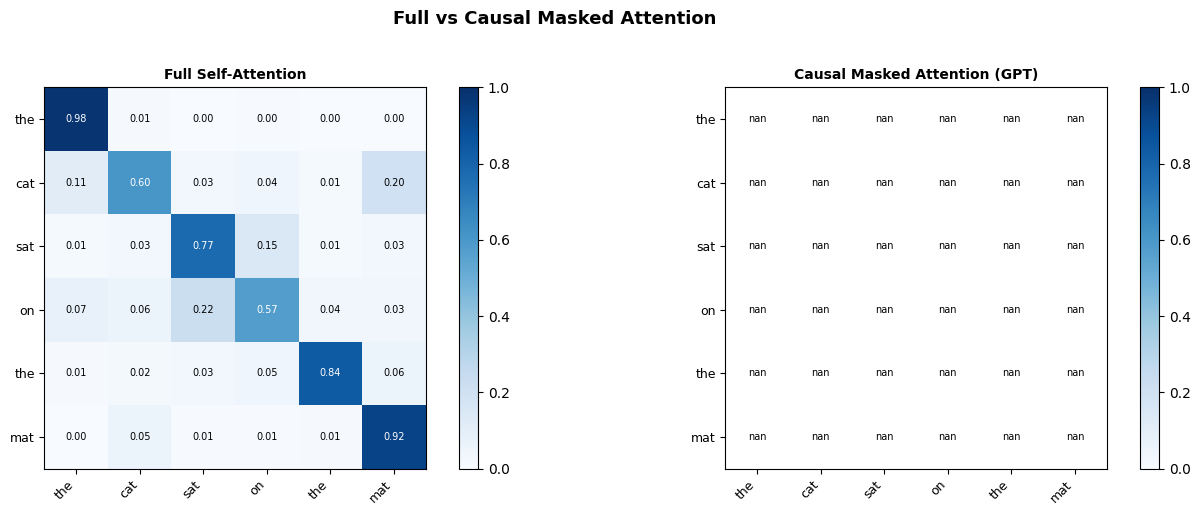

Saved: masked_attention.png

In causal attention: upper triangle = 0 (future tokens are invisible)


In [35]:
mask          = torch.triu(torch.ones(seq_len, seq_len), diagonal=1) * float('-inf')
masked_scores = scores + mask
masked_w      = F.softmax(masked_scores, dim=-1)
masked_ctx    = torch.matmul(masked_w, V)

print("Causal Mask (True = masked/blocked):")
print(torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool), diagonal=1).numpy())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, w, title in zip(axes,
    [attn_weights, masked_w],
    ["Full Self-Attention", "Causal Masked Attention (GPT)"]):
    im = ax.imshow(w.detach().numpy(), cmap='Blues', vmin=0, vmax=1)
    ax.set_xticks(range(seq_len)); ax.set_yticks(range(seq_len))
    ax.set_xticklabels(words_list, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(words_list, fontsize=9)
    for i in range(seq_len):
        for j in range(seq_len):
            v = w[i,j].item()
            ax.text(j,i,f"{v:.2f}",ha='center',va='center',fontsize=7,
                    color='white' if v>0.4 else 'black')
    plt.colorbar(im, ax=ax)
    ax.set_title(title, fontsize=10, fontweight='bold')

plt.suptitle("Full vs Causal Masked Attention", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("masked_attention.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: masked_attention.png")
print("\nIn causal attention: upper triangle = 0 (future tokens are invisible)")

---
## ⚖️ Cell 18 — Random vs Trained Embedding Comparison

In [37]:
random_emb = torch.nn.Embedding(int(V), int(EMBED_DIM)).weight.detach()

def cmp_sim(emb, w1, w2):
    if w1 not in w2i or w2 not in w2i: return 0
    v1 = emb[w2i[w1]].unsqueeze(0)
    v2 = emb[w2i[w2]].unsqueeze(0)
    return F.cosine_similarity(v1, v2).item()

pairs  = [("good","great"),("man","men"),("come","go"),("see","know"),("good","door"),("time","eye")]
r_sims = [cmp_sim(random_emb,   w1, w2) for w1, w2 in pairs]
t_sims = [cmp_sim(trained_embeddings, w1, w2) for w1, w2 in pairs]
lbls   = [f"{w1}↔{w2}" for w1, w2 in pairs]

x, w = np.arange(len(lbls)), 0.35
fig, ax = plt.subplots(figsize=(12, 5))
b1 = ax.bar(x-w/2, r_sims, w, label='Random',  color='#e74c3c', alpha=0.8)
b2 = ax.bar(x+w/2, t_sims, w, label='Trained', color='#2ecc71', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(lbls, rotation=15, ha='right', fontsize=9)
ax.set_ylabel("Cosine Similarity")
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_title("Random vs Trained Embeddings: Cosine Similarity", fontsize=13, fontweight='bold')
ax.legend(fontsize=10); ax.grid(axis='y', alpha=0.3)
for bars in [b1, b2]:
    for b in bars:
        ax.annotate(f"{b.get_height():.2f}",
                    xy=(b.get_x()+b.get_width()/2, b.get_height()),
                    xytext=(0,3), textcoords='offset points', ha='center', fontsize=7)
plt.tight_layout()
plt.savefig("random_vs_trained.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: random_vs_trained.png")

ValueError: only one element tensors can be converted to Python scalars

---
##  Cell 19 — Full Pipeline Summary

In [38]:
print("=" * 65)
print("       ENGLISH TOKENIZER & VECTOR EMBEDDINGS SUMMARY")
print("=" * 65)

s   = "Hello, I am building an LLM from scratch."
ids = tiktoken.get_encoding("gpt2").encode(s)
emb = torch.nn.Embedding(50257, 256)
pos = torch.nn.Embedding(len(ids), 256)
out = emb(torch.tensor(ids)) + pos(torch.arange(len(ids)))

print(f"\nInput        : {s}")
print(f"Token IDs    : {ids}")
print(f"Num tokens   : {len(ids)}")
print(f"Embed shape  : {out.shape}")

print("\n" + "-"*65)
concepts = [
    ("Regex Tokenizer",   "Splits text on whitespace + punctuation"),
    ("BPE Tokenizer",     "GPT-2 via tiktoken — 50,257 vocab"),
    ("Sliding Window",    "DataLoader for next-token prediction"),
    ("Token Embedding",   "nn.Embedding: ID -> dense vector"),
    ("Pos Embedding",     "Absolute position added to token vec"),
    ("Word2Vec CBOW",     "Train embeddings from context words"),
    ("Cosine Similarity", "Angle between vectors = semantic sim"),
    ("Embed Arithmetic",  "king - man + woman = queen"),
    ("Self-Attention",    "softmax(QKT/sqrt(d)) x V"),
    ("Causal Mask",       "GPT: no peeking at future tokens"),
    ("PCA / t-SNE",       "2D projection of embedding space"),
]
for name, desc in concepts:
    print(f"  [OK] {name:<22} {desc}")

print("\n" + "-"*65)
print("SAVED PLOTS")
saved = ["training_loss.png","pca_trained.png","tsne_trained.png",
         "cosine_heatmap.png","attention_weights.png",
         "masked_attention.png","random_vs_trained.png"]
for f in saved:
    status = "OK" if os.path.exists(f) else "MISSING"
    print(f"  [{status}] {f}")
print("=" * 65)

       ENGLISH TOKENIZER & VECTOR EMBEDDINGS SUMMARY

Input        : Hello, I am building an LLM from scratch.
Token IDs    : [15496, 11, 314, 716, 2615, 281, 27140, 44, 422, 12692, 13]
Num tokens   : 11
Embed shape  : torch.Size([11, 256])

-----------------------------------------------------------------
  [OK] Regex Tokenizer        Splits text on whitespace + punctuation
  [OK] BPE Tokenizer          GPT-2 via tiktoken — 50,257 vocab
  [OK] Sliding Window         DataLoader for next-token prediction
  [OK] Token Embedding        nn.Embedding: ID -> dense vector
  [OK] Pos Embedding          Absolute position added to token vec
  [OK] Word2Vec CBOW          Train embeddings from context words
  [OK] Cosine Similarity      Angle between vectors = semantic sim
  [OK] Embed Arithmetic       king - man + woman = queen
  [OK] Self-Attention         softmax(QKT/sqrt(d)) x V
  [OK] Causal Mask            GPT: no peeking at future tokens
  [OK] PCA / t-SNE            2D projection of embedd